In [17]:
import os
import sys
# Add the scripts folder to the Python path
sys.path.append(os.path.abspath("../scripts"))

In [18]:
import yfinance as yf 
import pandas as pd 
import numpy as np
from datetime import datetime  
from keras.models import Sequential
from keras.layers import Dense, LSTM
from visualization import plot_predictions

In [19]:
end=datetime.now()
start=datetime(end.year-15,end.month,end.day)
stock=('BTC-USD')
stock_data=yf.download(stock,start=start,end=end)

[*********************100%***********************]  1 of 1 completed


In [20]:
#closing price history
closing_price=stock_data[['Close']]

In [21]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(closing_price[['Close']].dropna())

In [22]:
len(scaled_data)

3773

In [23]:
#prepare data for LSTM  
x_data=[]
y_data =[]
base_days=100
for i in range(base_days,len(scaled_data)):
    x_data.append(scaled_data[i-base_days: i])
    y_data. append(scaled_data[i])
x_data= np.array(x_data)
y_data= np.array(y_data)

In [24]:
#split data into training and testing
train_size= int(len(x_data)*0.9)
x_train,y_train=x_data[:train_size],y_data[:train_size]
x_test,y_test=x_data[train_size:],y_data[train_size:] 

In [25]:
#reshape data for LSTM
model=Sequential(
    [
        LSTM(128,return_sequences=True,input_shape=(x_train.shape[1],1)),
        LSTM(64,return_sequences=False),
        Dense(25),
        Dense(1)
    ]
)
model.compile(optimizer='adam',loss='mean_squared_error')
model.summary()

d:\My project\Cryptocurrency-Bitcoin-Price-Prediction\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 100, 128)       │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 25)             │         1,625 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 117,619 (459.45 KB)

 Trainable params: 117,619 (459.45 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#model fitting
model.fit(x_train,y_train, batch_size=1, epochs=10)

Epoch 1/10
3305/3305 ━━━━━━━━━━━━━━━━━━━━ 407s 120ms/step - loss: 9.0639e-04
Epoch 2/10
3305/3305 ━━━━━━━━━━━━━━━━━━━━ 368s 111ms/step - loss: 2.4575e-04
Epoch 3/10
3305/3305 ━━━━━━━━━━━━━━━━━━━━ 5140s 2s/step - loss: 2.5116e-04
Epoch 4/10
3305/3305 ━━━━━━━━━━━━━━━━━━━━ 459s 133ms/step - loss: 1.6689e-04
Epoch 5/10
3305/3305 ━━━━━━━━━━━━━━━━━━━━ 4049s 1s/step - loss: 1.3296e-04
Epoch 6/10
3305/3305 ━━━━━━━━━━━━━━━━━━━━ 470s 141ms/step - loss: 1.5793e-04
Epoch 7/10
3305/3305 ━━━━━━━━━━━━━━━━━━━━ 479s 134ms/step - loss: 1.2844e-04
Epoch 8/10
3305/3305 ━━━━━━━━━━━━━━━━━━━━ 535s 144ms/step - loss: 1.1307e-04
Epoch 9/10
3100/3305 ━━━━━━━━━━━━━━━━━━━━ 4:28 1s/step - loss: 1.3009e-04

In [ ]:
predictions=model.predict(x_test)
inv_predictions=scaler.inverse_transform(predictions)
inv_y_test=scaler.inverse_transform(y_test)

12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 215ms/step


In [12]:
plotting_data = pd.DataFrame(
    {
    'Original' :inv_y_test.flatten(),
    ' Prediction':inv_predictions.flatten(),
    },index= closing_price.index[train_size + base_days:]
)

In [13]:
plotting_data.columns = plotting_data.columns.str.strip()


In [14]:
print(plotting_data.columns)


Index(['Original', 'Prediction'], dtype='object')


ValueError: x and y must have same first dimension, but have shapes (368,) and (1,)

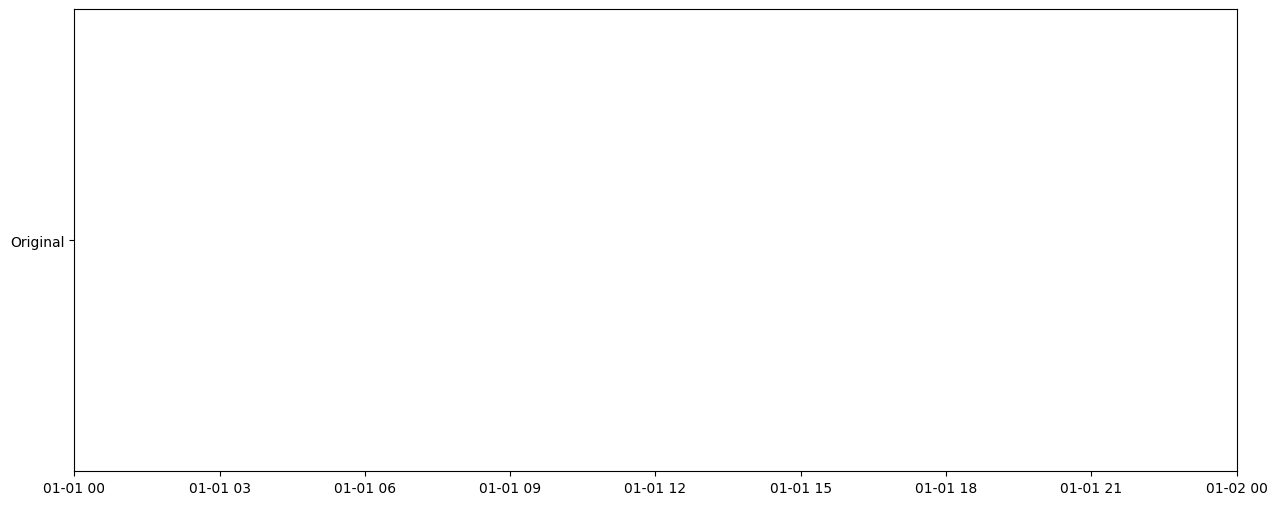

In [16]:
plot_predictions(plotting_data)


In [12]:
print(plotting_data.columns)


Index(['Original', ' Prediction'], dtype='object')


In [ ]:
#price prediction for next day
last_100= scaled_data[-100:].reshape(1,100,1)
future_predictions=[]
for _ in range(10):
    next_days=model.predict(last_100)
    future_predictions.append(scaler.inverse_transform(next_days))
    last_100=np.append(last_100[:,1:,:],next_days.reshape(1,1,-1),axis=1)

In [ ]:
future_predictions=np.array(future_predictions).flaten()